# Evaluation Scenario 2

In [1]:
import json
import sympy
from mira.metamodel import *
from mira.modeling.amr.petrinet import template_model_to_petrinet_json
from copy import deepcopy

In [2]:
c = lambda x: Concept(name=x, units=Unit(expression=s('person')))
s = lambda x: sympy.Symbol(x)

### Set up parameters with values and units

In [3]:
params = {
    'beta': (0.18, s('person')/s('day')),
    'rih': (0.07, 1/s('day')),
    'rhi': (0.07, 1/s('day')),
    'rhr': (0.07, 1/s('day')),
    'rhd': (0.3, 1/s('day')),
    'pir': (0.9, 1),
    'pih': (0.1, 1),
    'phr': (0.87, 1),
    'phd': (0.13, 1),
    'N': (150e6, s('person')),
    'I0': (1000, s('person')),
    'R0': (0, s('person')),
    'H0': (0, s('person')),
    'D0': (781454, s('person'))
}

### Implement base model templates and initials

In [4]:
templates = [
    ControlledConversion(subject=c('S'), outcome=c('I'),
                         controller=c('I'),
                         rate_law=s('beta')*s('I')*s('S')/s('N')),
    NaturalConversion(subject=c('I'), outcome=c('R'),
                      rate_law=s('rir')*s('pir')*s('I')),
    NaturalConversion(subject=c('I'), outcome=c('H'),
                      rate_law=s('rih')*s('pih')*s('I')),
    NaturalConversion(subject=c('H'), outcome=c('D'),
                      rate_law=s('rhd')*s('phd')*s('H')),
    NaturalConversion(subject=c('H'), outcome=c('R'),
                      rate_law=s('rhr')*s('phr')*s('H')),
    
]

In [5]:
initials = {
    'S0': Initial(concept=c('S'), expression=s('N')-s('I0')-s('R0')-s('H0')-s('D0')),
    'I0': Initial(concept=c('I'), expression=s('I0')),
    'R0': Initial(concept=c('R'), expression=s('R0')),
    'H0': Initial(concept=c('H'), expression=s('H0')),
    'D0': Initial(concept=c('D'), expression=s('D0')),
}

In [6]:
parameters = {
    p: Parameter(name=p, value=v, units=Unit(expression=u))
    for p, (v, u) in params.items()
}

Instantiate the template model

In [7]:
tm = TemplateModel(
    templates=templates,
    initials=initials,
    parameters=parameters
)

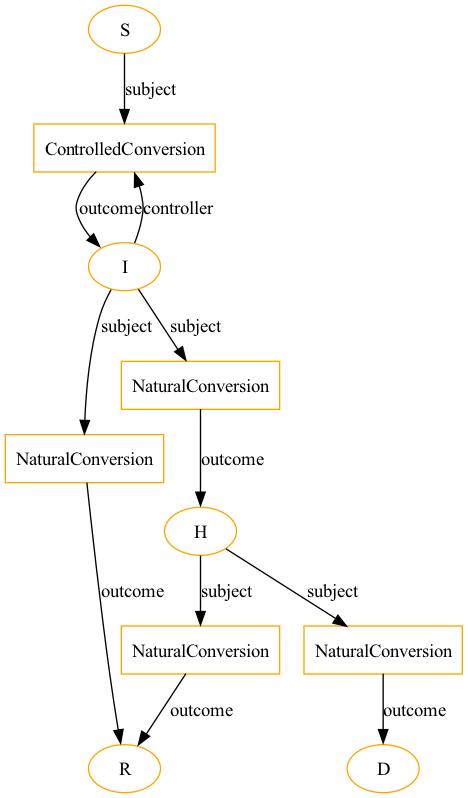

In [8]:
tm.draw_jupyter()

In [9]:
with open('scenario2_q1_petrinet.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm), fh, indent=1)

## Implement one-step vaccination

In [10]:
tm_vax = deepcopy(tm)
tm_vax = stratify(tm_vax,
                  strata=['u', 'v'],
                  key='vax',
                  concepts_to_stratify=['S', 'I', 'H', 'R'],
                  structure=[],
                  cartesian_control=True,
                  params_to_preserve=['N'])

tm_vax.templates.append(
    NaturalConversion(subject=c('S_u').with_context(vax='u'),
                      outcome=c('S_v').with_context(vax='v'),
                      rate_law=s('S_u')*s('v_a')*s('v_b'))
)
tm_vax.parameters['v_a'] = Parameter(name='v_a', value=0.3,
                                     units=Unit(expression=1/s('day')))
tm_vax.parameters['v_b'] = Parameter(name='v_b', value=1.0,
                                     units=Unit(expression=1))

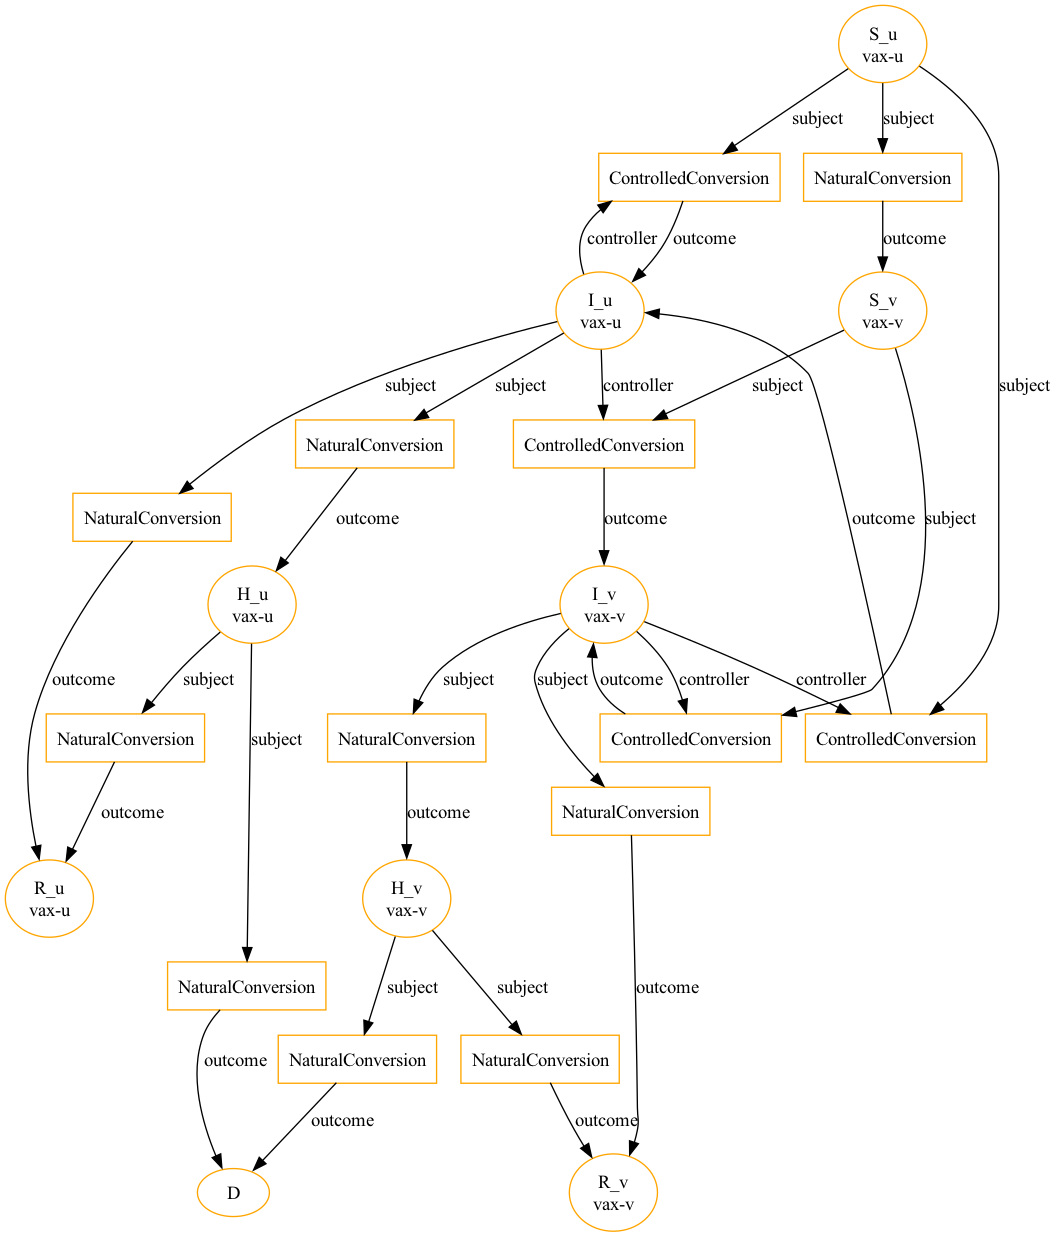

In [11]:
tm_vax.draw_jupyter()

In [12]:
with open('scenario2_q4_petrinet.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm_vax), fh, indent=1)

## Implement testing

In [13]:
tm_test = deepcopy(tm_vax)

In [14]:
tm_test.parameters['p_test_acc'] = Parameter(name='p_test_acc', value=0.75)
tm_test.parameters['p_dec_transm_min'] = Parameter(name='p_dec_transm_min', value=0.25)
tm_test.parameters['p_dec_transm_max'] = Parameter(name='p_dec_transm_max', value=0.5)

p_dec_transm = s('p_dec_transm_min') + s('t')*(s('p_dec_transm_max') - s('p_dec_transm_min')) / 60
rate_factor = (1 - s('p_test_acc')) * (1 - p_dec_transm)

for template in tm_test.templates:
    if 'beta' in str(template.rate_law.args[0]):
        template.rate_law = SympyExprStr(template.rate_law.args[0] * rate_factor)

In [15]:
with open('scenario2_q8_petrinet.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm_test), fh, indent=1)

## Implement testing + multi-stage vaccination

First we reimplement testing on the base model

In [16]:
tm_base_test = deepcopy(tm)

tm_base_test.parameters['p_test_acc'] = Parameter(name='p_test_acc', value=0.75)
tm_base_test.parameters['p_dec_transm_min'] = Parameter(name='p_dec_transm_min', value=0.25)
tm_base_test.parameters['p_dec_transm_max'] = Parameter(name='p_dec_transm_max', value=0.5)

p_dec_transm = s('p_dec_transm_min') + s('t')*(s('p_dec_transm_max') - s('p_dec_transm_min')) / 60
rate_factor = (1 - s('p_test_acc')) * (1 - p_dec_transm)

for template in tm_base_test.templates:
    if 'beta' in str(template.rate_law.args[0]):
        template.rate_law = SympyExprStr(template.rate_law.args[0] * rate_factor)

In [17]:
tm_strat = deepcopy(tm_base_test)

Next we reimplement vaccination, now in two steps

In [18]:
tm_strat = stratify(tm_strat,
                    strata=['u', 'v1', 'v2'],
                    key='vax',
                    concepts_to_stratify=['S', 'I', 'H', 'R'],
                    structure=[],
                    cartesian_control=True,
                    params_to_preserve=['N', 'p_test_acc', 'p_dec_transm_min', 'p_dec_transm_max'])

tm_vax.templates.extend([
    NaturalConversion(subject=c('S_u').with_context(vax='u'),
                      outcome=c('S_v1').with_context(vax='v1'),
                      rate_law=s('S_u')*s('v1_a')*s('v1_b')),
    NaturalConversion(subject=c('S_v1').with_context(vax='v1'),
                      outcome=c('S_v2').with_context(vax='v2'),
                      rate_law=s('S_v1')*s('v2_a')*s('v2_b'))
])
tm_vax.parameters['v1_a'] = Parameter(name='v1_a', value=0.3,
                                     units=Unit(expression=1/s('day')))
tm_vax.parameters['v1_b'] = Parameter(name='v1_b', value=1.0,
                                     units=Unit(expression=1))
tm_vax.parameters['v2_a'] = Parameter(name='v2_a', value=0.3,
                                     units=Unit(expression=1/s('day')))
tm_vax.parameters['v2_b'] = Parameter(name='v2_b', value=1.0,
                                     units=Unit(expression=1))

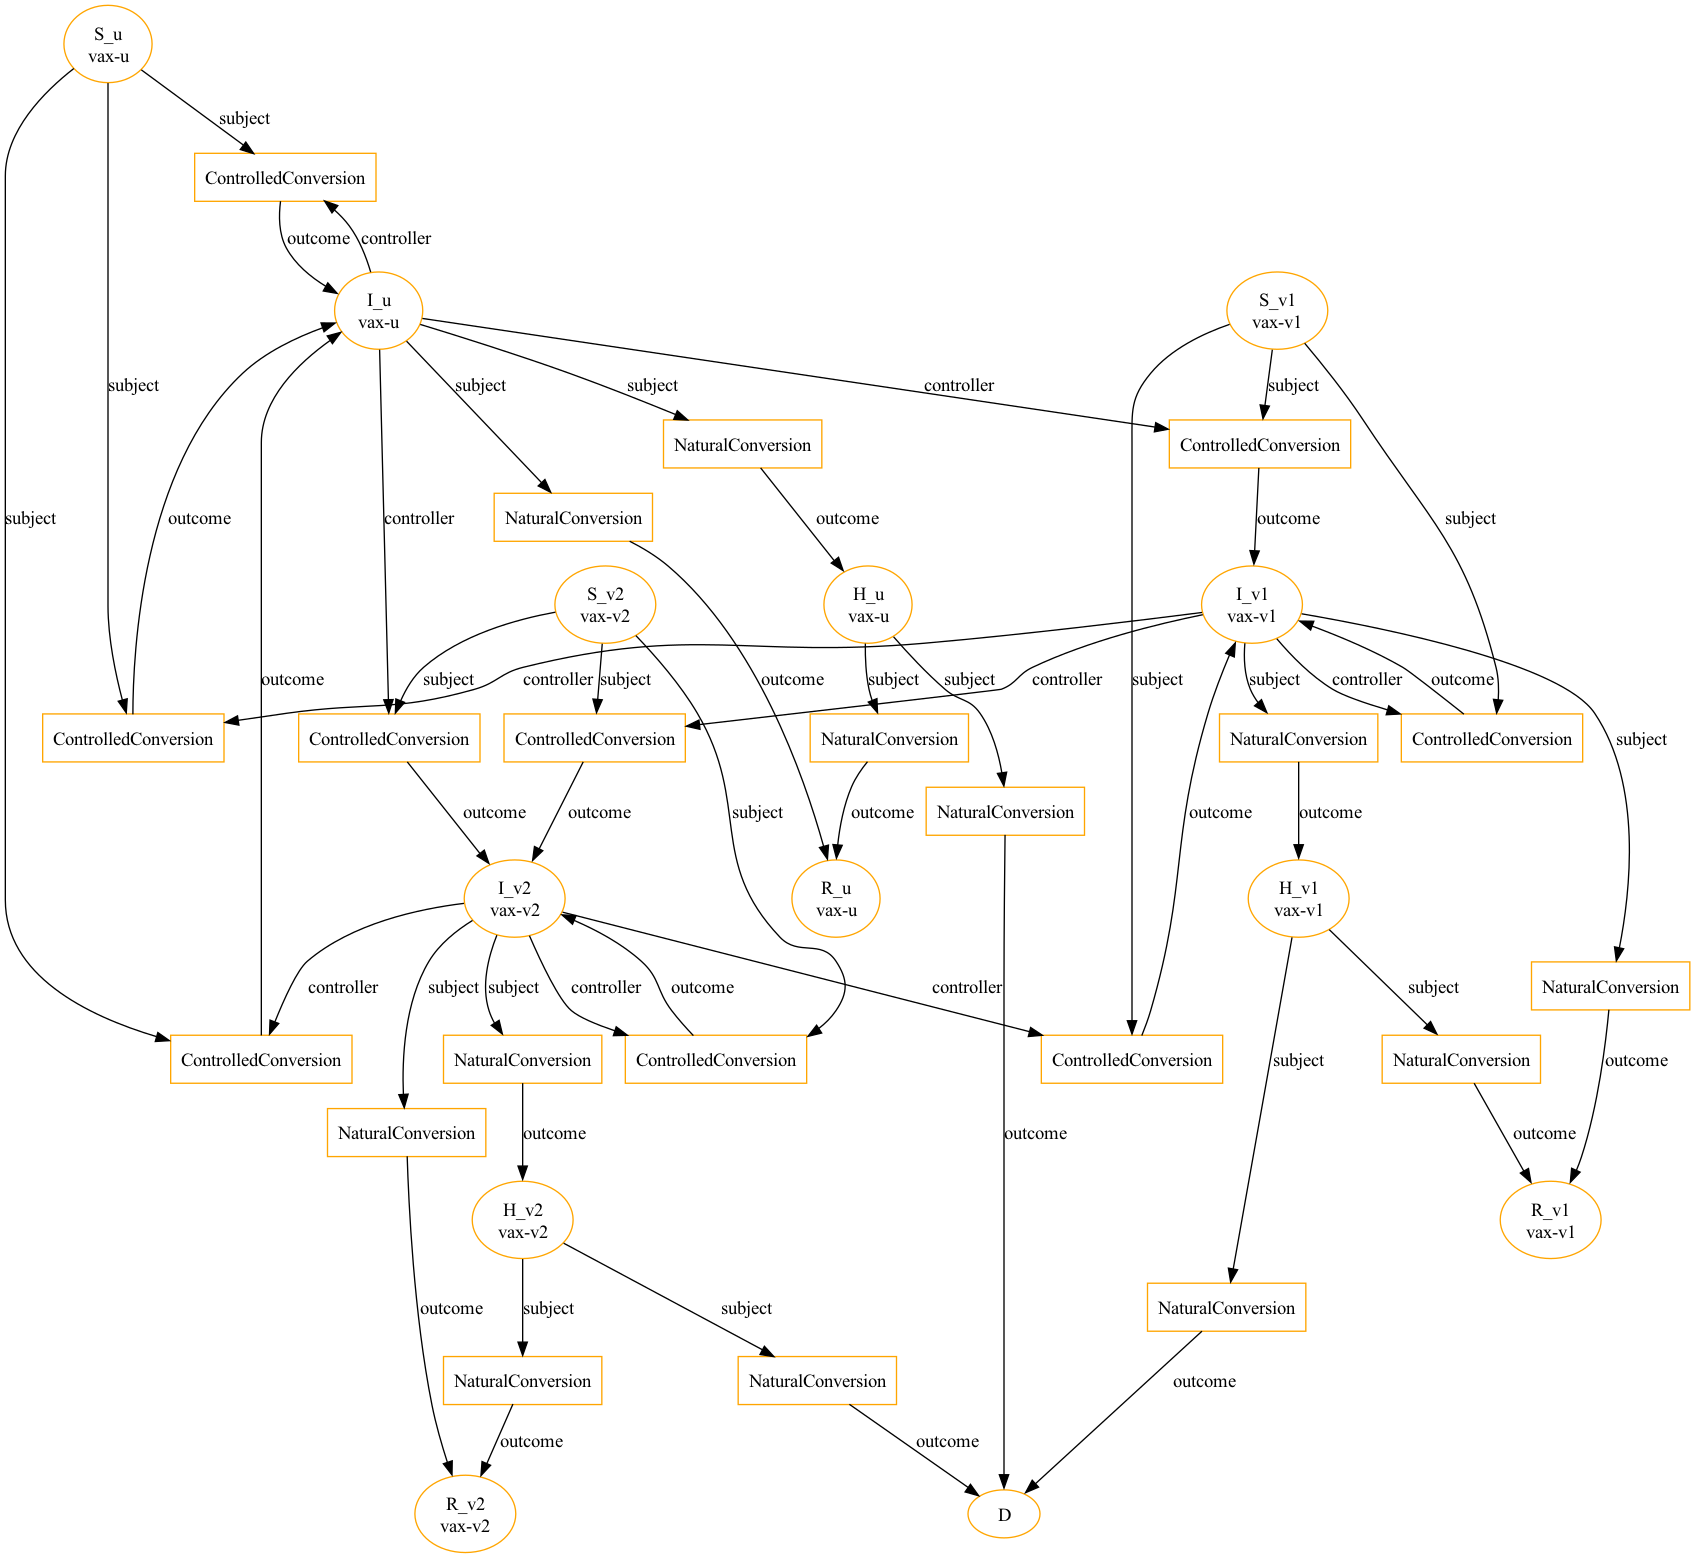

In [19]:
tm_strat.draw_jupyter()

### Stratify by age, sex, ethnicity

In [20]:
tm_strat = stratify(tm_strat,
                    strata=['young', 'old'],
                    key='age',
                    structure=[],
                    cartesian_control=True,
                    params_to_preserve=['N'])

In [ ]:
tm_strat.draw_jupyter()

In [22]:
tm_strat = stratify(tm_strat,
                    strata=['m', 'f'],
                    key='sex',
                    structure=[],
                    cartesian_control=True,
                    params_to_preserve=['N'])

In [23]:
tm_strat.draw_jupyter()

In [24]:
tm_strat = stratify(tm_strat,
                    strata=['hisp', 'nonhisp'],
                    key='ethnicity',
                    structure=[],
                    cartesian_control=True,
                    params_to_preserve=['N'])

In [26]:
#tm_strat.draw_jupyter()

In [27]:
with open('scenario2_q9_petrinet.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(tm_strat), fh, indent=1)